In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import os
import re
warnings.filterwarnings('ignore')

Matplotlib is building the font cache; this may take a moment.


## Read Train data

In [20]:
train_home_team_statistics_df = pd.read_csv('/Users/gabriellima/Documents/Competitions/DataQRT/Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('/Users/gabriellima/Documents/Competitions/DataQRT/Train_Data/train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('/Users/gabriellima/Documents/Competitions/DataQRT/Y_train_1rknArQ.csv', index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})

In [6]:
train_data.head()

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,3.0,6.0,...,5.0,5.0,4.0,0.0,6.0,8.0,4.0,3.0,2.0,3.0
1,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,6.0,8.0,...,0.0,0.0,3.0,1.0,8.0,4.0,10.0,0.0,5.0,3.0
2,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,2.0,7.0,...,6.0,10.0,4.0,4.0,0.0,8.0,3.0,0.0,9.0,6.0
3,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,2.0,0.0,...,0.0,0.0,1.0,2.0,0.0,5.0,6.0,3.0,NaN,2.0
4,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,4.0,7.0,...,1.0,0.0,4.0,4.0,9.0,4.0,1.0,4.0,6.0,5.0


In [16]:
train_scores.head()

,HOME_WINS,DRAW,AWAY_WINS
ID,,,
0,0,0,1
1,0,1,0
2,0,0,1
3,1,0,0
4,0,1,0


In [26]:
from sklearn.preprocessing import LabelEncoder

def get_result(row):
    if row['HOME_WINS'] == 1:
        return 'HOME_WINS'
    elif row['DRAW'] == 1:
        return 'DRAW'
    elif row['AWAY_WINS'] == 1:
        return 'AWAY_WINS'
    else:
        return 'UNKNOWN'

train_scores['RESULT'] = train_scores.apply(get_result, axis=1)

# Remover as colunas originais
train_scores = train_scores.drop(columns=['HOME_WINS', 'DRAW', 'AWAY_WINS'])

# Aplicar Label Encoding na coluna RESULT
label_encoder = LabelEncoder()
train_scores['RESULT'] = label_encoder.fit_transform(train_scores['RESULT'])

In [42]:
train_scores.head()

,RESULT
ID,
0,0
1,1
2,0
3,2
4,1


In [28]:
def count_nan_values(df: pd.DataFrame, pct = 0.15) -> list[str]:
    series_missing_values = (df.isna().sum()/df.shape[0]).sort_values(ascending=False)
    drop_columns = series_missing_values[series_missing_values > pct].index
    return drop_columns

In [43]:
drop_columns = count_nan_values(train_data, .1)

# Identify columns to keep
keep_columns = train_data.columns.difference(drop_columns)

# Drop the identified columns from the DataFrame
train_data_cleaned = train_data[keep_columns]

print(keep_columns)

Index(['AWAY_TEAM_ATTACKS_5_last_match_average',
       'AWAY_TEAM_ATTACKS_5_last_match_std',
       'AWAY_TEAM_ATTACKS_5_last_match_sum',
       'AWAY_TEAM_ATTACKS_season_average', 'AWAY_TEAM_ATTACKS_season_std',
       'AWAY_TEAM_ATTACKS_season_sum',
       'AWAY_TEAM_BALL_POSSESSION_5_last_match_average',
       'AWAY_TEAM_BALL_POSSESSION_5_last_match_std',
       'AWAY_TEAM_BALL_POSSESSION_season_average',
       'AWAY_TEAM_BALL_POSSESSION_season_std',
       ...
       'HOME_TEAM_SUBSTITUTIONS_5_last_match_sum',
       'HOME_TEAM_SUBSTITUTIONS_season_average',
       'HOME_TEAM_SUBSTITUTIONS_season_std',
       'HOME_TEAM_SUBSTITUTIONS_season_sum',
       'HOME_TEAM_YELLOWCARDS_5_last_match_average',
       'HOME_TEAM_YELLOWCARDS_5_last_match_std',
       'HOME_TEAM_YELLOWCARDS_5_last_match_sum',
       'HOME_TEAM_YELLOWCARDS_season_average',
       'HOME_TEAM_YELLOWCARDS_season_std', 'HOME_TEAM_YELLOWCARDS_season_sum'],
      dtype='object', length=210)


### Imputer

In [44]:
train_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12303 entries, 0 to 12302
Columns: 210 entries, AWAY_TEAM_ATTACKS_5_last_match_average to HOME_TEAM_YELLOWCARDS_season_sum
dtypes: float64(210)
memory usage: 20.1 MB


In [45]:
# Identify numerical columns
numerical_cols = train_data_cleaned.select_dtypes(include=['number']).columns

# Identify categorical columns
categorical_cols = train_data_cleaned.select_dtypes(include=['object', 'category']).columns

# Create the imputers
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputers on the training data
if not numerical_cols.empty:
    numerical_imputer.fit(train_data_cleaned[numerical_cols])

if not categorical_cols.empty:
    categorical_imputer.fit(train_data_cleaned[categorical_cols])

# Create copies of the DataFrames to avoid modifying the original ones
train_data_fillna = train_data_cleaned.copy()
# test_data_fillna = test_data_cleaned.copy()

# Transform the training data
if not numerical_cols.empty:
    train_data_fillna[numerical_cols] = numerical_imputer.transform(train_data_cleaned[numerical_cols])
    # test_data_fillna[numerical_cols] = numerical_imputer.transform(test_data_cleaned[numerical_cols])

if not categorical_cols.empty:
    train_data_fillna[categorical_cols] = categorical_imputer.transform(train_data_cleaned[categorical_cols])
    # test_data_fillna[categorical_cols] = categorical_imputer.transform(test_data_cleaned[categorical_cols])

## Training


### train, valid test split

In [48]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data_fillna, train_scores, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

In [52]:
y_valid.RESULT.unique()

array([1, 2, 0])

### xgb model

In [49]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric':'mlogloss'
    }


d_train = xgb.DMatrix(X_train.replace({0:np.nan}), y_train)
d_valid = xgb.DMatrix(X_valid.replace({0:np.nan}), y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)

XGBoostError: [17:48:54] /Users/runner/work/xgboost/xgboost/src/objective/multiclass_obj.cu:111: SoftmaxMultiClassObj: label must be in [0, num_class).
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000017a8ece28 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000017ab5942c xgboost::obj::SoftmaxMultiClassObj::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::linalg::Tensor<xgboost::detail::GradientPairInternal<float>, 2>*) + 684
  [bt] (2) 3   libxgboost.dylib                    0x000000017aad36e4 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 692
  [bt] (3) 4   libxgboost.dylib                    0x000000017a90e3e4 XGBoosterUpdateOneIter + 144
  [bt] (4) 5   libffi.dylib                        0x00000001961a2050 ffi_call_SYSV + 80
  [bt] (5) 6   libffi.dylib                        0x00000001961aaadc ffi_call_int + 1208
  [bt] (6) 7   _ctypes.cpython-312-darwin.so       0x0000000106f979e8 _ctypes_callproc + 808
  [bt] (7) 8   _ctypes.cpython-312-darwin.so       0x0000000106f90a14 PyCFuncPtr_call + 216
  [bt] (8) 9   Python                              0x0000000104c2b4f0 _PyObject_MakeTpCall + 128



In [53]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import log_loss

# Define the parameter grid
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.025, 0.05, 0.1],
    'n_estimators': [100, 500, 1000, 2000],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

# Initialize the model
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', use_label_encoder=False)

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_log_loss',
    cv=StratifiedKFold(n_splits=5),
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the RandomizedSearchCV
random_search.fit(X_train.replace({0: np.nan}), y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters found: ", best_params)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, subsample=0.8; total time=   5.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, subsample=0.8; total time=   5.7s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, subsample=0.8; total time=   5.9s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=500, subsample=0.8; total time=   5.7s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.025, max_depth=10, min_child_weight=5, n_estimators=1000, subsample=1.0; total time=  20.1s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.025, max_depth=10, min_child_weight=5, n_estimators=1000, subsample=1.0; total time=  20.8s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.025, max_depth=10, min_child_weight=5, n_estimators=1000, subsample=1.0; total time=  20.8s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.025, max_depth=10, min_child_weight=5, n_estimators=1000, subsample=1.0; total time=  20.9s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.025, max_depth=10, min_child_weight=5, n_estimators=1000, subsample=1.0; total time=  20.8s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.025, max_depth=6, min_child_weight=5, n_estimators=1000, subsample=1.0; total time=  15.8s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.025, max_depth=6, min_child_weight=5, n_estimators=1000, subsample=1.0; total time=  16.1s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.025, max_depth=6, min_child_weight=5, n_estimators=1000, subsample=1.0; total time=  16.6s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.025, max_depth=6, min_child_weight=5, n_estimators=1000, subsample=1.0; total time=  17.5s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.025, max_depth=6, min_child_weight=5, n_estimators=1000, subsample=1.0; total time=  18.0s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=2000, subsample=0.8; total time=  20.2s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=2000, subsample=0.8; total time=  20.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=2000, subsample=0.8; total time=  20.8s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=2000, subsample=0.8; total time=  21.0s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   4.9s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   5.1s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=2000, subsample=0.8; total time=  21.7s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   4.8s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   4.8s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   4.7s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=2000, subsample=0.8; total time=  26.8s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=500, subsample=0.6; total time=   6.4s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=500, subsample=0.6; total time=   6.5s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=500, subsample=0.6; total time=   6.4s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=500, subsample=0.6; total time=   6.4s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=500, subsample=0.6; total time=   6.6s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=2000, subsample=0.8; total time=  27.1s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=2000, subsample=0.8; total time=  27.4s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=2000, subsample=0.8; total time=  27.1s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=2000, subsample=0.8; total time=  27.4s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, subsample=0.6; total time=  13.3s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, subsample=0.6; total time=  13.2s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, subsample=0.6; total time=  13.3s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, subsample=0.6; total time=  13.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=500, subsample=0.6; total time=  12.9s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500, subsample=1.0; total time=   5.7s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500, subsample=1.0; total time=   5.8s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500, subsample=1.0; total time=   5.8s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500, subsample=1.0; total time=   5.9s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.025, max_depth=6, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   2.6s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.025, max_depth=6, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.025, max_depth=6, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   2.5s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500, subsample=1.0; total time=   6.1s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.025, max_depth=6, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.025, max_depth=6, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   2.5s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:52:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=500, subsample=0.6; total time=  22.5s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:53:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=500, subsample=0.6; total time=  23.1s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:53:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=500, subsample=0.6; total time=  23.2s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:53:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=500, subsample=0.6; total time=  22.3s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:53:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=500, subsample=0.6; total time=  22.6s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:53:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=2000, subsample=0.8; total time= 1.5min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:53:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=2000, subsample=0.8; total time= 1.5min
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=2000, subsample=0.8; total time= 1.5min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:53:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:53:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=2000, subsample=0.8; total time= 1.6min
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=2000, subsample=0.8; total time= 1.6min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:54:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:54:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=2000, subsample=1.0; total time=  26.1s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:54:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=2000, subsample=1.0; total time=  26.5s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:54:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=2000, subsample=1.0; total time=  26.6s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:54:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=2000, subsample=1.0; total time=  27.1s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:54:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, subsample=1.0; total time=  22.8s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=2000, subsample=1.0; total time=  26.9s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:54:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, subsample=1.0; total time=  22.8s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:55:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, subsample=1.0; total time=  22.6s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:55:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, subsample=1.0; total time=  23.2s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:55:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=2000, subsample=0.6; total time= 2.5min
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=1000, subsample=1.0; total time=  22.2s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:55:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:55:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=1000, subsample=0.8; total time=  27.2s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:55:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=1000, subsample=0.8; total time=  27.3s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:55:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=100, subsample=0.8; total time=  10.3s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=1000, subsample=0.8; total time=  27.0s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=1000, subsample=0.8; total time=  26.9s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=100, subsample=0.8; total time=  10.8s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=100, subsample=0.8; total time=  10.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=1000, subsample=0.8; total time=  27.7s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=2000, subsample=0.6; total time= 2.8min
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=100, subsample=0.8; total time=  10.5s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=2000, subsample=0.6; total time= 2.8min
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=100, subsample=0.8; total time=  10.2s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=100, subsample=0.8; total time=  11.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=100, subsample=0.8; total time=  11.4s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=100, subsample=0.8; total time=  11.3s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=100, subsample=0.8; total time=  11.2s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=8, min_child_weight=3, n_estimators=100, subsample=0.8; total time=  11.1s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=2000, subsample=0.6; total time= 2.7min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.9s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.9s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.8s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=2000, subsample=0.6; total time= 2.7min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.7s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.6; total time=   2.9s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:56:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=1000, subsample=0.6; total time=  35.9s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=1000, subsample=0.6; total time=  36.3s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=1000, subsample=0.6; total time=  36.6s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.025, max_depth=8, min_child_weight=3, n_estimators=1000, subsample=0.8; total time= 1.0min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.025, max_depth=8, min_child_weight=3, n_estimators=1000, subsample=0.8; total time=  59.9s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.025, max_depth=8, min_child_weight=3, n_estimators=1000, subsample=0.8; total time= 1.0min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   8.9s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.025, max_depth=8, min_child_weight=3, n_estimators=1000, subsample=0.8; total time= 1.0min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.025, max_depth=8, min_child_weight=3, n_estimators=1000, subsample=0.8; total time=  59.7s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   9.1s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   8.9s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   9.1s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   8.7s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.025, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  20.7s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.025, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  20.2s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=1000, subsample=0.6; total time=  35.8s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.025, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  21.3s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=1000, subsample=0.6; total time=  35.9s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.025, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  21.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.025, max_depth=10, min_child_weight=1, n_estimators=100, subsample=1.0; total time=  20.5s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, subsample=0.8; total time=  24.2s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, subsample=0.8; total time=  25.3s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, subsample=0.8; total time=  25.3s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, subsample=0.8; total time=  25.1s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, subsample=0.8; total time=  25.6s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=2000, subsample=1.0; total time=  29.7s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=2000, subsample=1.0; total time=  29.6s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=2000, subsample=1.0; total time=  30.2s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=2000, subsample=1.0; total time=  30.0s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=2000, subsample=1.0; total time=  29.4s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=500, subsample=0.6; total time=  36.2s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=500, subsample=0.6; total time=  36.2s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=500, subsample=0.6; total time=  36.2s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=500, subsample=0.6; total time=  35.8s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=500, subsample=0.6; total time=  35.5s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:58:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.6; total time= 1.5min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:15:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.6; total time=17.1min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:15:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.025, max_depth=6, min_child_weight=1, n_estimators=2000, subsample=0.6; total time=16.8min
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.025, max_depth=6, min_child_weight=1, n_estimators=2000, subsample=0.6; total time=16.8min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:15:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.6; total time=17.0min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:15:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:15:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.025, max_depth=6, min_child_weight=1, n_estimators=2000, subsample=0.6; total time=16.8min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:15:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.6; total time=17.0min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:15:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.6; total time=17.1min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:15:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=2000, subsample=0.8; total time= 2.7min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:18:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=2000, subsample=0.8; total time= 2.7min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:18:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=2000, subsample=0.8; total time= 2.7min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:18:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=2000, subsample=0.8; total time= 2.7min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:18:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=2000, subsample=0.8; total time= 2.7min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:18:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.025, max_depth=6, min_child_weight=1, n_estimators=2000, subsample=0.6; total time= 3.2min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:18:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   5.6s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:18:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.025, max_depth=6, min_child_weight=1, n_estimators=2000, subsample=0.6; total time= 3.1min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:18:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   5.4s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:18:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   5.6s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:18:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=100, subsample=1.0; total time= 4.9min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:23:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=100, subsample=1.0; total time= 4.9min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:23:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=500, subsample=1.0; total time= 7.8min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:23:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.025, max_depth=4, min_child_weight=5, n_estimators=500, subsample=0.6; total time= 5.0min


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:23:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.025, max_depth=4, min_child_weight=5, n_estimators=500, subsample=0.6; total time=  13.9s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:23:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.025, max_depth=4, min_child_weight=5, n_estimators=500, subsample=0.6; total time=  14.1s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:23:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.025, max_depth=4, min_child_weight=5, n_estimators=500, subsample=0.6; total time=  14.5s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:23:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.025, max_depth=4, min_child_weight=5, n_estimators=500, subsample=0.6; total time=  15.0s


/Users/gabriellima/Documents/Competitions/qrt-competition/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:24:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [41]:
y_train.unique()

array([1, 0])

In [35]:
from sklearn.model_selection import cross_val_score

# Define the best parameters
params_optimized = {
    'booster': 'gbtree',
    'tree_method': 'hist',
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'],
    'min_child_weight': best_params['min_child_weight'],
    'objective': 'multi:softprob',
    'num_class': 2,  # Ensure this matches your actual number of classes
    'eval_metric': 'mlogloss'
}

# Create the DMatrix
d_train = xgb.DMatrix(X_train.replace({0: np.nan}), y_train)
d_valid = xgb.DMatrix(X_valid.replace({0: np.nan}), y_valid)

# Train the model with early stopping
num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_optimized, d_train, num_round, evallist, early_stopping_rounds=100)

# Cross-Validation Scores
cv_results = cross_val_score(random_search.best_estimator_, X_train.replace({0: np.nan}), y_train, cv=StratifiedKFold(n_splits=5), scoring='neg_log_loss')
print("Cross-Validation Log Loss: ", -cv_results.mean())


[0]	train-mlogloss:0.68657	eval-mlogloss:0.68780
[1]	train-mlogloss:0.68023	eval-mlogloss:0.68273
[2]	train-mlogloss:0.67410	eval-mlogloss:0.67792
[3]	train-mlogloss:0.66815	eval-mlogloss:0.67311
[4]	train-mlogloss:0.66239	eval-mlogloss:0.66848
[5]	train-mlogloss:0.65690	eval-mlogloss:0.66432
[6]	train-mlogloss:0.65159	eval-mlogloss:0.66012
[7]	train-mlogloss:0.64646	eval-mlogloss:0.65609
[8]	train-mlogloss:0.64156	eval-mlogloss:0.65237
[9]	train-mlogloss:0.63684	eval-mlogloss:0.64875
[10]	train-mlogloss:0.63208	eval-mlogloss:0.64529
[11]	train-mlogloss:0.62763	eval-mlogloss:0.64183
[12]	train-mlogloss:0.62324	eval-mlogloss:0.63853
[13]	train-mlogloss:0.61898	eval-mlogloss:0.63567
[14]	train-mlogloss:0.61496	eval-mlogloss:0.63263
[15]	train-mlogloss:0.61098	eval-mlogloss:0.62972
[16]	train-mlogloss:0.60723	eval-mlogloss:0.62706
[17]	train-mlogloss:0.60362	eval-mlogloss:0.62459
[18]	train-mlogloss:0.59997	eval-mlogloss:0.62224
[19]	train-mlogloss:0.59639	eval-mlogloss:0.61987
[20]	train

### Some analysis

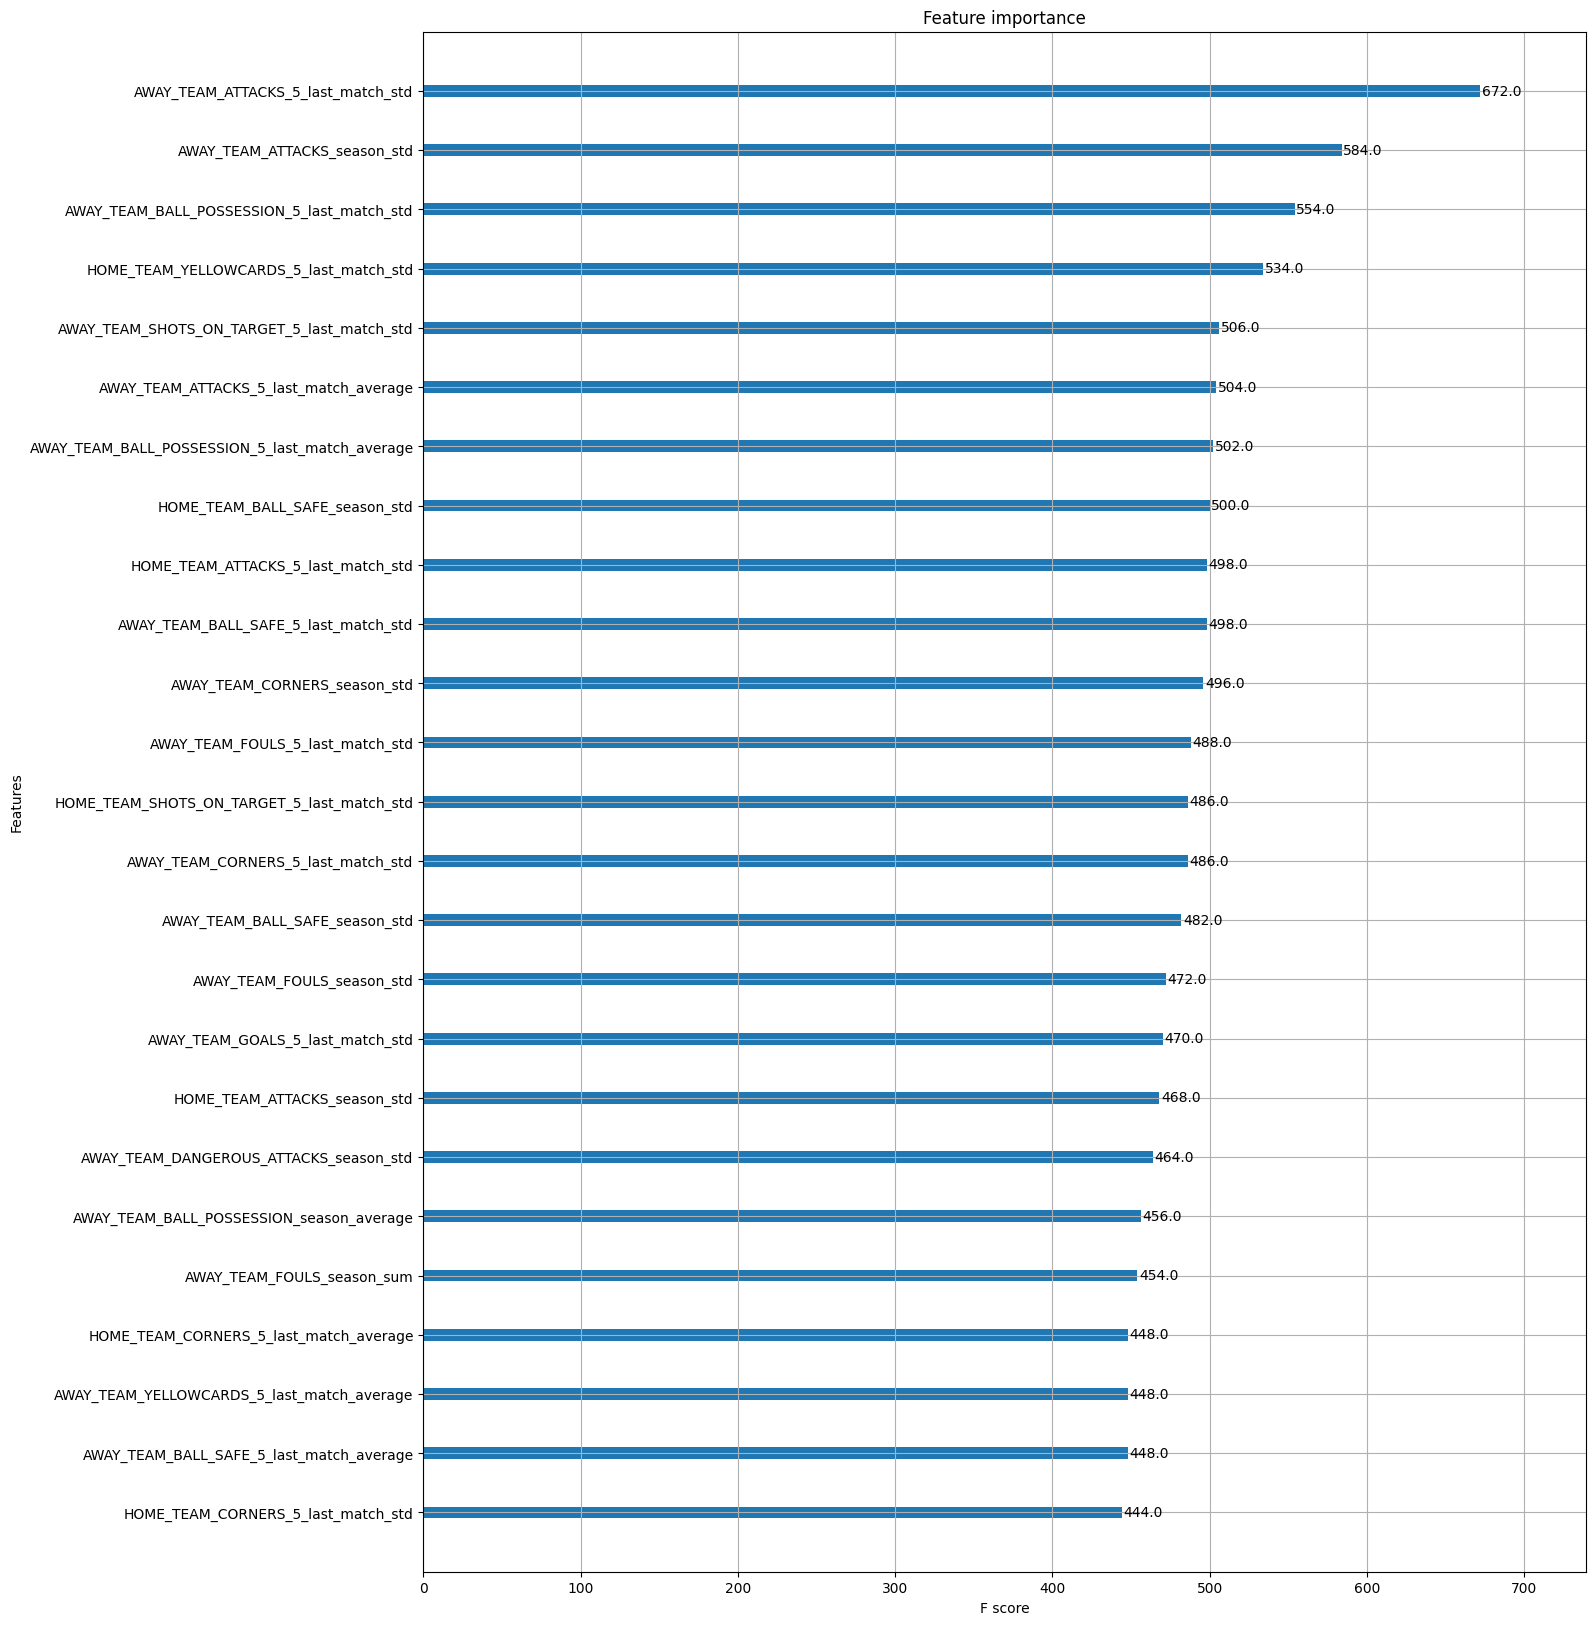

In [17]:
xgb.plot_importance(bst, max_num_features=25)
fig = plt.gcf()
fig.set_size_inches(15, 20)

### Accuracy on test set

Using our model

In [36]:
X_test_xgb = xgb.DMatrix(X_test)

predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

In [37]:
predictions.head()

,0,1
0,0.828889,0.171111
1,0.676090,0.323910
2,0.535909,0.464091
3,0.495888,0.504112
4,0.757614,0.242386


In [18]:
X_test_xgb = xgb.DMatrix(X_test)

predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values

target = train_scores.loc[X_test.index].copy()

np.round(accuracy_score(predictions,target),4)


0.475

## Submission

In [19]:
test_home = pd.read_csv('/Users/gabriellima/Documents/Competitions/DataQRT/Test_Data/test_home_team_statistics_df.csv', index_col=0)
test_away = pd.read_csv('/Users/gabriellima/Documents/Competitions/DataQRT/Test_Data/test_away_team_statistics_df.csv', index_col=0)

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1)

test_data_clean = test_data[keep_columns]

In [20]:
test_data_fillna = test_data_clean.copy()

# Transform the training data
if not numerical_cols.empty:
    test_data_fillna[numerical_cols] = numerical_imputer.transform(test_data_fillna[numerical_cols])

if not categorical_cols.empty:
    test_data_fillna[categorical_cols] = categorical_imputer.transform(test_data_fillna[categorical_cols])

In [21]:
X_bench = xgb.DMatrix(test_data_fillna)

predictions = bst.predict(X_bench, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int)

predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
predictions.index = test_data.index
submission = predictions.reset_index()

# Find the highest index of existing submission files
existing_files = [f for f in os.listdir('../submissions/') if re.match(r'submission_\d+\.csv', f)]
max_index = 0

for file in existing_files:
    match = re.match(r'submission_(\d+)\.csv', file)
    if match:
        index = int(match.group(1))
        if index > max_index:
            max_index = index

# Increment the index for the new file
new_index = max_index + 1
submission_file_name = f'../submissions/submission_{new_index}.csv'

# Save the new submission file
submission.to_csv(submission_file_name, index=False)

print(f"Saved the submission file as: {submission_file_name}")

Saved the submission file as: ../submissions/submission_3.csv
